# Download e pre-processamento dos dados
### Nessa etapa inical, estaremos baixando o dataset Minds 14 (en-us), que contém aproximadamente 1h15m de áudios (sample rate de 8000) de fala na língua inglesa divididos em amostras de tempo variado (em torno de alguns segundos).

### Após isso, divideremos as amostras em trechos de 1 segundo, obtendo 4586 exemplos. Cada exemplo é formado por um vetor 8000-dimensional, o qual estaremos convertendo para espectrogramas de 260x260.

### Finalmente, normalizaremos (mean=0, std=1) os espectrogramas e faremos um split de treino e validação de 90-10.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requi

###Imports

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from scipy.signal import stft, istft
import numpy as np
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

### Donwload do dataset


In [4]:
# Responda com 'y' quando rodar

dataset = load_dataset("PolyAI/minds14", "en-US")

audio_data = [dataset['train'][i]['audio']['array'] for i in range(len(dataset['train']))]

### Transformar os dados de áudio em imagens através de STFT e normalizar.


#### Utilizaremos a função de Short-Term Fourier Transform da biblioteca scipy. Os parametros foram escolhidos de forma a gerarem imagens quadradas e não terem perda de qualidade quando forem transformados de volta para áudio em forma de vetor.

In [7]:
def divide_into_one_second_excerpts(audio_vectors):
    excerpts = []
    for audio_vector in audio_vectors:
        N = len(audio_vector)
        num_excerpts = N // 8000  # Número de trechos de 1 segundo

        for i in range(num_excerpts):
            start_index = i * 8000
            excerpt = audio_vector[start_index:start_index + 8000]
            excerpts.append(excerpt)
    return excerpts

def standardize(spectrograms):
    mean = np.mean(spectrograms)
    std = np.std(spectrograms)
    standardized_spectrograms = (spectrograms - mean) / std
    return standardized_spectrograms, mean, std

def de_standardize(spectrograms, mean, std):
    return spectrograms * std + mean

audio_excerpts = divide_into_one_second_excerpts(audio_data)
spectrograms = [stft(vector, fs=8000, nperseg=519, noverlap=488)[2].astype(np.float32) for vector in audio_excerpts]
spectrograms = np.array(spectrograms, dtype=np.float32)

# Standardize the spectrograms
spectrograms, mean, std = standardize(spectrograms)

<ipython-input-7-d82028b922b8>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrograms = [stft(vector, fs=8000, nperseg=519, noverlap=488)[2].astype(np.float32) for vector in audio_excerpts]


### Train val test split

#### Estaremos dividindo o dataset em um conjuto de treino e um conjunto de teste na proporção 90-10. Em seguida, separaremos 10% do conjunto de treino para ser utilizado como conjunto de validação.

#### Em outras palavras, do nosso dataset, 10% dos dados serão utilizados para teste, 9% para validação e 81% para treino do modelo.

In [16]:
# Define the sizes of train and test sets
train_size = int(0.9 * len(spectrograms)) - 1  # 90% training
test_size = len(spectrograms) - train_size  # Remaining for testing

# Split dataset into train and test
train, test = random_split(spectrograms, [train_size, test_size])


train_size, val_size = int(0.9 * train_size) + 1, int(0.1 * train_size)
train, val = random_split(train, [train_size, val_size])



# Create DataLoader instances
train_loader = DataLoader(train, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=False)

#VQ-VAE Model

### Implementaremos um Vector-Quantized Variational Autoencoder utilizando uma Unet com SE blocks.

###Imports


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from scipy.signal import stft, istft
from torch.utils.data import DataLoader, ConcatDataset
import math
import torch
import numpy as np
import torch.nn.functional as F

### Definição do modelo

In [19]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def block(in_channels, features, reduction=16, dropout_prob=0.1):
    return nn.Sequential(
        nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Conv2d(features, features, kernel_size=3, padding=1, bias=True),
        nn.BatchNorm2d(features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        SEBlock(features, reduction)
    )


class Encoder(nn.Module):
    def __init__(self, in_channels, init_features):
        super(Encoder, self).__init__()
        features = init_features
        self.enc1 = block(in_channels, features)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = block(features, features * 2)
        self.enc3 = block(features * 2, features * 4)
        self.enc4 = block(features * 4, features * 8)
        self.bottleneck = block(features * 8, features * 16)

    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.pool(enc1)
        enc2 = self.enc2(pool1)
        pool2 = self.pool(enc2)
        enc3 = self.enc3(pool2)
        pool3 = self.pool(enc3)
        enc4 = self.enc4(pool3)
        pool4 = self.pool(enc4)
        bottleneck = self.bottleneck(pool4)
        return bottleneck, enc4, enc3, enc2, enc1

class Decoder(nn.Module):
    def __init__(self, out_channels, init_features):
        super(Decoder, self).__init__()
        features = init_features
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = block(features * 2, features)
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x, enc4, enc3, enc2, enc1):
        dec4 = self.upconv4(x)
        dec4 = self._resize(dec4, enc4.size(2), enc4.size(3))
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self._resize(dec3, enc3.size(2), enc3.size(3))
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self._resize(dec2, enc2.size(2), enc2.size(3))
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self._resize(dec1, enc1.size(2), enc1.size(3))
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _resize(layer, height, width):
        return nn.functional.interpolate(layer, size=(height, width), mode='bilinear', align_corners=True)

class VQVAE_UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64, num_embeddings=512, embedding_dim=64):
        super(VQVAE_UNet, self).__init__()
        self.encoder = Encoder(in_channels, init_features)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim)
        self.decoder = Decoder(out_channels, init_features)

    def forward(self, x):
        z_e, enc4, enc3, enc2, enc1 = self.encoder(x)
        z_q, loss, _ = self.quantizer(z_e)
        x_recon = self.decoder(z_q, enc4, enc3, enc2, enc1)
        return x_recon, loss

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embedding_table = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding_table.weight.data.uniform_(-1/math.sqrt(self.num_embeddings), 1/math.sqrt(self.num_embeddings))

    def forward(self, z):

        z_flattened = z.view(-1, self.embedding_dim)
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     + torch.sum(self.embedding_table.weight**2, dim=1)
                     - 2 * torch.matmul(z_flattened, self.embedding_table.weight.t()))
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)
        z_q = torch.matmul(encodings, self.embedding_table.weight).view(z.shape)
        loss = torch.mean((z_q.detach() - z)**2) + self.commitment_cost * torch.mean((z_q - z.detach())**2)
        z_q = z + (z_q - z).detach()
        return z_q, loss, encoding_indices

### Loop de treinamento

#### Treinaremos o modelo com 20 épocas utilizando o otimizador AdamW, regularizador L1 e scheduler de learning rate para reduzir no platô.

In [ ]:
vqvae_model = VQVAE_UNet(in_channels=1, out_channels=1, init_features=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vqvae_model = vqvae_model.to(device)
optimizer = optim.AdamW(vqvae_model.parameters(), lr=0.004)
criterion = nn.MSELoss()
l1_criterion = nn.L1Loss()

num_epochs = 20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


for epoch in range(num_epochs):
    vqvae_model.train()
    train_loss = 0.0
    for data in train_loader:
        data = data.to(device)
        data = data.unsqueeze(1)
        data_noisy = data.to(device) + 1.0 * torch.randn(data.shape).to(device) # Adjust noise level as needed
        optimizer.zero_grad()
        reconstructed_data, quantization_loss = vqvae_model(data_noisy)
        mse_loss = criterion(reconstructed_data, data)
        l1_loss = l1_criterion(reconstructed_data, data)
        reconstruction_loss = mse_loss + 0.5 * l1_loss
        total_loss = reconstruction_loss + quantization_loss
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    train_loss /= len(train_loader)

    vqvae_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data = data.unsqueeze(1)
            data_noisy = data.to(device) + 1.0 * torch.randn(data.shape).to(device)
            reconstructed_data, quantization_loss = vqvae_model(data_noisy)
            mse_loss = criterion(reconstructed_data, data)
            l1_loss = l1_criterion(reconstructed_data, data)
            reconstruction_loss = mse_loss + 0.5 * l1_loss
            total_loss = reconstruction_loss + quantization_loss
            val_loss += total_loss.item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch [1/20], Train Loss: 0.090466, Val Loss: 0.072571
Epoch [2/20], Train Loss: 0.090488, Val Loss: 0.075508
Epoch [3/20], Train Loss: 0.085608, Val Loss: 0.069829
Epoch [4/20], Train Loss: 0.082807, Val Loss: 0.089939
Epoch [5/20], Train Loss: 0.080188, Val Loss: 0.069342
Epoch [6/20], Train Loss: 0.080489, Val Loss: 0.067644
Epoch [7/20], Train Loss: 0.079186, Val Loss: 0.069839
Epoch [8/20], Train Loss: 0.079271, Val Loss: 0.068371
Epoch [9/20], Train Loss: 0.075132, Val Loss: 0.073151
Epoch [10/20], Train Loss: 0.074511, Val Loss: 0.065561
Epoch [11/20], Train Loss: 0.072380, Val Loss: 0.059219
Epoch [12/20], Train Loss: 0.073170, Val Loss: 0.062873
Epoch [13/20], Train Loss: 0.073279, Val Loss: 0.071028
Epoch [14/20], Train Loss: 0.072965, Val Loss: 0.057271
Epoch [15/20], Train Loss: 0.070219, Val Loss: 0.060431
Epoch [16/20], Train Loss: 0.070906, Val Loss: 0.056988
Epoch [17/20], Train Loss: 0.071961, Val Loss: 0.058681
Epoch [18/20], Train Loss: 0.070498, Val Loss: 0.071549
E

### Opcional: salvar o modelo ou carregar um pré-treinado

#### Salvar o modelo no Drive

In [ ]:
torch.save(vqvae_model.state_dict(), 'model36.pth')


In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')


# Define source and destination paths
src = 'model36.pth'
dst = '/content/drive/My Drive/model36.pth'

# Copy the file
shutil.copy(src, dst)

# Verify the file transfer
print(os.listdir('/content/drive/My Drive'))


Mounted at /content/drive


#### Carregar um pré-treinado pelo Drive

In [20]:
from google.colab import drive
import shutil
import torch
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your model file
model_path = '/content/drive/MyDrive/model36.pth'


# Load the state_dict into the model
vqvae_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
vqvae_model.eval()

Mounted at /content/drive


VQVAE_UNet(
  (encoder): Encoder(
    (enc1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(

# Experimentos

### Incialmente, faremos a avaliação visual dos espectrogramas antes a depois de fazer o denoising.

### Em seguida, avaliaremos perceptualmente os áudios, disponibilizando eles para serem baixados e reproduzidos.

### Finalmente, computaremos as métricas de avaliação (STOI, PESQ, NSR).

### Avaliação visual

In [55]:
import matplotlib.pyplot as plt

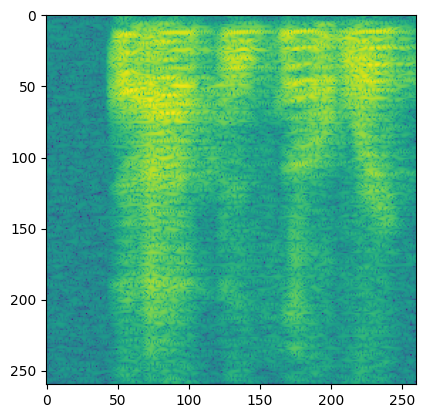

In [56]:
spect = test[37]
plt.imshow(np.log(np.abs(spect)))

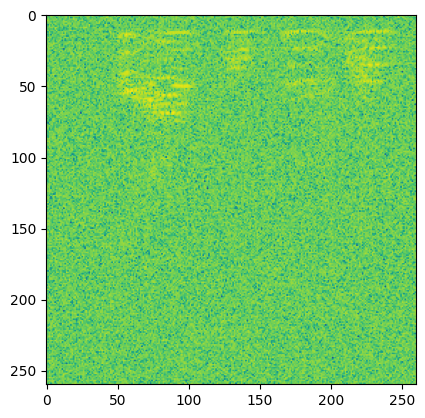

In [57]:
noisy_spect = spect + 1.0 * np.random.randn(*test[320].shape)
plt.imshow(np.log(np.abs(noisy_spect)))

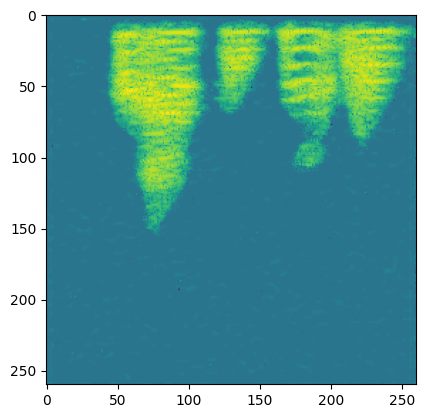

In [58]:
out = (torch.tensor(noisy_spect, dtype=torch.float32).reshape(1, 1, 260, 260).to(device))
denoised = vqvae_model(out)[0]
denoised = denoised.detach().cpu().reshape(260,260)
plt.imshow(np.log(denoised.abs()))

### Avaliação perceptual

In [59]:
denoised_audio = istft(de_standardize(denoised, mean, std), 8000, nperseg=519, noverlap=488)[1]
good_audio = istft(de_standardize(spect, mean, std), 8000, nperseg=519, noverlap=488)[1]
noised = istft(de_standardize(noisy_spect, mean, std), 8000, nperseg=519, noverlap=488)[1]

In [ ]:
from scipy.io.wavfile import write

In [ ]:
write('denoised_audio.wav', 8000, denoised_audio)
write('original_audio.wav', 8000, good_audio)
write('noisy_audio.wav', 8000, (noised * 2.0).astype(np.float32))

#### Aqui, testaremos o denoising em um áudio completo do dataset (o que pode incluir trechos de treino, teste ou validação)

In [ ]:
from scipy.io.wavfile import write
def divide_excerpts(audio_vector):
    excerpts = []

    N = len(audio_vector)
    num_excerpts = N // 8000  # Number of complete 1-second excerpts

    for i in range(num_excerpts):
        start_index = i * 8000
        excerpt = audio_vector[start_index:start_index + 8000]
        excerpts.append(excerpt)
    return excerpts

# Escolher um áudio do dataset
audio_sample = audio_data[373]

# Dividir em trechos de 1 segundo
audio1 = divide_excerpts(audio_sample)

# Computar espectrogramas
spectrograms = [stft(vector, fs=8000, nperseg=519, noverlap=488)[2].astype(np.float32) for vector in audio1]

spectrograms = np.array(spectrograms, dtype=np.float32)

# Estandardizar os espectrogramas
spectrograms, mean, std = standardize(spectrograms)

# Desestandardizar, fazer ISTFT, e concatenar
good_audio_segments = [istft(de_standardize(spect, mean, std), fs=8000, nperseg=519, noverlap=488)[1] for spect in spectrograms]
good_audio = np.concatenate(good_audio_segments)


noisy_spects = [spect + 1.0 * np.random.randn(*train[400].shape) for spect in spectrograms]
outs = [(torch.tensor(noisy_spect, dtype=torch.float32).reshape(1, 1, 260, 260).to(device) - 0) for noisy_spect in noisy_spects]
denoised = [vqvae_model(out)[0] for out in outs]

denoised = [denoised_spect.detach().cpu().reshape(260,260) for denoised_spect in denoised]

denoised_audio_segments = [istft(de_standardize(denoised, mean, std), fs=8000, nperseg=519, noverlap=488)[1] for denoised in denoised]
denoised_audio = np.concatenate(denoised_audio_segments)

noised_audio_segments = [istft(de_standardize(noised, mean, std), fs=8000, nperseg=519, noverlap=488)[1] for noised in noisy_spects]
noised_audio = np.concatenate(noised_audio_segments)

write('original.wav', 8000, good_audio)
write('noised.wav', 8000, (noised_audio * 2.0).astype(np.float32))
write('denoised.wav', 8000, (denoised_audio * 1.5).astype(np.float32))

<ipython-input-80-4d48798a3dc2>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrograms = [stft(vector, fs=8000, nperseg=519, noverlap=488)[2].astype(np.float32) for vector in audio1]


### Computação das métricas de avaliação

In [ ]:
!pip install pystoi
!pip install pesq

def calculate_nsr(clean_signal, noisy_signal):
    noise_signal = noisy_signal - clean_signal
    signal_power = np.mean(clean_signal ** 2)
    noise_power = np.mean(noise_signal ** 2)
    nsr_value = noise_power / signal_power
    return nsr_value

In [66]:
original_audio_list = []
noised_audio_list = []
denoised_audio_list = []


for sample in test:

    noisy_spect = sample + 1.0 * np.random.randn(*sample.shape)
    noisy_spect = (torch.tensor(noisy_spect, dtype=torch.float32).reshape(1, 1, 260, 260).to(device))

    denoised = vqvae_model(out)[0]
    denoised = denoised.detach().cpu().reshape(260,260)

    denoised_audio = istft(de_standardize(denoised, mean, std), 8000, nperseg=519, noverlap=488)[1]
    good_audio = istft(de_standardize(spect, mean, std), 8000, nperseg=519, noverlap=488)[1]
    noised = istft(de_standardize(noisy_spect.detach().cpu(), mean, std), 8000, nperseg=519, noverlap=488)[1]

    original_audio_list.append(good_audio)
    noised_audio_list.append(noised)
    denoised_audio_list.append(denoised_audio)


#### Computar a média das métricas no conjunto de teste

#### As interpretrações dos resultados, bem como a conclusão, estão disponíveis no relatório

In [67]:
stoi_noised_original = 0
stoi_denoised_original = 0
pesq_noised_original = 0
pesq_denoised_original = 0
nsr_noised_original = 0
nsr_denoised_original = 0
nsr_noised_denoised = 0

In [77]:
sampling_rate = 8000

for original_sample, noised_sample, denoised_sample in zip(original_audio_list,
                                                           noised_audio_list,
                                                           denoised_audio_list):
    # a conversão retorna lenght de 8030
    original_sample = original_sample[:8000]
    denoised_sample = denoised_sample[:8000]
    noised_sample = noised_sample[0][0][:8000]


    stoi_noised = stoi(original_sample, noised_sample, sampling_rate, extended=False)
    stoi_denoised = stoi(original_sample, denoised_sample, sampling_rate, extended=False)

    pesq_noised = pesq(sampling_rate, original_sample, noised_sample, 'nb')
    pesq_denoised = pesq(sampling_rate, original_sample, denoised_sample, 'nb')

    nsr_noised = calculate_nsr(original_sample, noised_sample)
    nsr_denoised1 = calculate_nsr(original_sample, denoised_sample)
    nsr_denoised2 = calculate_nsr(denoised_sample, noised_sample)

    stoi_noised_original += stoi_noised
    stoi_denoised_original += stoi_denoised
    pesq_noised_original += pesq_noised
    pesq_denoised_original += pesq_denoised
    nsr_noised_original += nsr_noised
    nsr_denoised_original += nsr_denoised1
    nsr_noised_denoised += nsr_denoised2

stoi_noised_original = stoi_noised_original     / len(test)
stoi_denoised_original = stoi_denoised_original / len(test)
pesq_noised_original = pesq_noised_original     / len(test)
pesq_denoised_original = pesq_denoised_original / len(test)
nsr_noised_original = nsr_noised_original       / len(test)
nsr_denoised_original = nsr_denoised_original   / len(test)
nsr_noised_denoised = nsr_noised_denoised       / len(test)

In [86]:
print("---------- MÉTRICAS DE AVALIAÇÃO NO CONJUNTO DE TESTE ----------")
print()
print(f'STOI (Noised vs Original): {stoi_noised_original:.3f}')
print(f'STOI (Denoised vs Original): {stoi_denoised_original:.3f}')
print(f'PESQ (Noised vs Original): {pesq_noised_original:.3f}')
print(f'PESQ (Denoised vs Original): {pesq_denoised_original:.3f}')
print(f'NSR (Noised vs Original): {nsr_noised_original:.3f}')
print(f'NSR (Denoised vs Original): {nsr_denoised_original:.3f}')
print(f'NSR (Noised vs Denoised): {nsr_noised_denoised:.3f}')
print()
print("----------------------------------------------------------------")

---------- MÉTRICAS DE AVALIAÇÃO NO CONJUNTO DE TESTE ----------

STOI (Noised vs Original): 0.248
STOI (Denoised vs Original): 0.852
PESQ (Noised vs Original): 1.178
PESQ (Denoised vs Original): 2.477
NSR (Noised vs Original): 3.520
NSR (Denoised vs Original): 0.052
NSR (Noised vs Denoised): 3.532

----------------------------------------------------------------
